### Data mining goal
We aim to investigate the effect of chemicals (phosphate, ammonium, nitrate) together with precipitation on the oxygen level by means of predicting the oxygen in the influent water before the water is treated and drained into the environment. 

### Model choice

Based on observation of data assumption we have decided to use Random Forest Regression. Main reasons behind the choice of this model are its properties such as: flexibility to outliers, proneness to overfitting, handling of non-linear and skewed data. These characteristics align nicely with our data which makes this model a suitable choice for achieving our data mining goal. 

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score,mean_absolute_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import export_graphviz
from sklearn import tree
import os

In [216]:

def create_features(df :pd.DataFrame):
    """
    Function that will encode time as a trigonometric function (sin, cos, etc.)
    
    Args:
    df (pd.DataFrame): DataFrame with a datetime index.

    Returns:
    pd.DataFrame: DataFrame with added time-based and cyclic features. 
    
    TODO: added error handling and improper use of provided dataset
	"""
    df['minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    
    # Sine and cosine transformations for cyclic features																
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df.dropna(inplace=True)
    
    return df

As we are dealing with time series data, we have to take past values into account due to autocorrelation. This means that the past values of features will be supplied as features to the training dataset.

In [217]:
def add_lags(df):
    target_map = df['oxygenValue'].to_dict()
    df['lag_1']=(df.index - pd.Timedelta('1 hour')).map(target_map)
    df['lag_2']=(df.index - pd.Timedelta('2 hour')).map(target_map)
    df['lag_3']=(df.index - pd.Timedelta('3 hour')).map(target_map)
    return df

Here we are loading the merged data set which contains all of the relevant features and target values. All values are **cleaned**.

**Target**: oxygenValue

**Features**: nitrateValue, phosphateValue, waterFlowPerMinute, precipitation

In [218]:
df = pd.read_parquet('../../data/cleanedData/allDataClient.parquet') #alternatively you can supply path as 'allDataClient.parquet'
df.set_index('measurementDate', inplace=True)
df.dropna(inplace=True)
df.describe()

,oxygenValue,nitrateValue,phosphateValue,ammoniumValue,waterFlowPerMinute,precipitation
count,525466.000000,525466.000000,525466.000000,525466.000000,5.254660e+05,525466.000000
mean,0.592245,3.957458,-582.327359,3.610626,1.764362e+06,0.001736
std,0.651725,2.022106,493.221976,2.944485,1.440768e+06,0.006019
min,0.000000,0.073000,-999.000000,0.000000,1.422770e+04,0.000000
25%,0.023500,2.450000,-999.000000,1.367000,6.189565e+05,0.000000
50%,0.296500,3.516000,-999.000000,3.011000,1.539993e+06,0.000000
75%,1.145500,4.948000,0.757000,5.107000,2.556421e+06,0.000000
max,3.000000,9.988000,5.994000,19.985000,8.082788e+06,0.096667


Specila case of k-fold validation to account for the time series data. 

In [219]:
nFolds = 5
tss = TimeSeriesSplit(n_splits=nFolds, test_size=60*24*30, gap=60*24)
df = df.sort_index()

Splitting data set into the train and test set which is sunsequently visualized using target values 

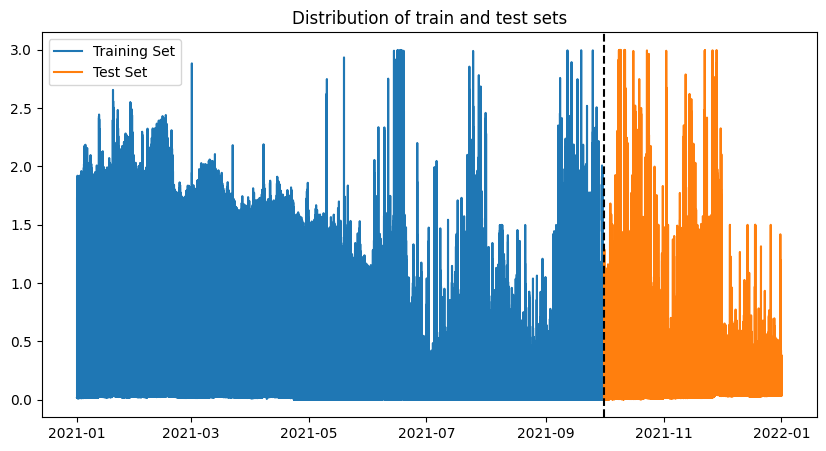

In [220]:
graph_train = df.loc[df.index<'2021-10-01']
graph_test = df.loc[df.index>='2021-10-01']

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(graph_train.index,graph_train['oxygenValue'])
plt.plot(graph_test.index,graph_test['oxygenValue'])
ax.axvline(pd.to_datetime('2021-10-01'),color='black', ls='--')
plt.title("Distribution of train and test sets")
plt.legend(['Training Set','Test Set'])
plt.show()

Extracting features and target to the appropriate variables according to our data mining goal. In addition to the chemical values, the features contain lag values to account for autocorrelation and various time measurements expressed by trigonometric functions to account for the seasonality of the data.

In [221]:
FEATURES = ['nitrateValue', 'phosphateValue', 'ammoniumValue',
            'waterFlowPerMinute', 'precipitation', 'minute_sin', 'minute_cos',
            'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
            'quarter_sin', 'quarter_cos', 'month_sin', 'month_cos',
            'lag_1', 'lag_2', 'lag_3']
TARGET = 'oxygenValue'

df = create_features(df)
df= add_lags(df)
df.dropna(inplace=True)
train = df.loc[df.index<'2021-10-01'] # 80 percent
test = df.loc[df.index>='2021-10-01'] # 20 percent
X_train_data, y_train_data = train[FEATURES],train[TARGET] # 80 percent features and target
X_test_data, y_test_data = test[FEATURES],test[TARGET] # 20 percent features and target

Setting up the model

In [222]:
fold = 0
preds =[]
scores =[]
r2_scores = []
mae_scores = []

paramsRF = {
    "bootstrap": True,
    "ccp_alpha": 0.0,
    "criterion": "squared_error",
    "max_depth": 10,
    "max_features": 50,
    "max_leaf_nodes": None,
    "max_samples": None,
    "min_impurity_decrease": 0.0,
    "min_samples_leaf": 20,
    "min_samples_split": 10,
    "min_weight_fraction_leaf": 0.0,
    "n_estimators": 170,
    "n_jobs": -1,
    "oob_score": False,
    "random_state": None,
    "verbose": 0,
    "warm_start": False
}



rfr = None

Actual Modeling Using Random Forest Regression Algorithm

Hyperparameters Stored in Separate Dictionary for Better Manipulation

We've experimented with hyperparameters but haven't achieved optimal tuning.  We're considering using grid search to find the best ones.

In [223]:
for train_idx, val_idx in tss.split(train):
    fold_train = df.iloc[train_idx].copy()
    fold_test = df.iloc[val_idx].copy()

    scaler = MinMaxScaler(feature_range=(0,1))
    FEATURES_TO_SCALE = ['nitrateValue', 'phosphateValue', 'ammoniumValue',
            'waterFlowPerMinute','lag_1', 'lag_2', 'lag_3']
   
   
    X_train, y_train = fold_train[FEATURES], fold_train[TARGET]
    X_test, y_test = fold_test[FEATURES], fold_test[TARGET]

    reg = RandomForestRegressor(**paramsRF)
    reg.fit(X_train, y_train)
    fold += 1

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = root_mean_squared_error(y_test, y_pred)
    scores.append(score)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)


([<matplotlib.axis.YTick at 0x7f0f1423cf80>,
 [Text(0, 0, 'Fold 5'),
  Text(0, 1, 'Fold 4'),
  Text(0, 2, 'Fold 3'),
  Text(0, 3, 'Fold 2'),
  Text(0, 4, 'Fold 1')])

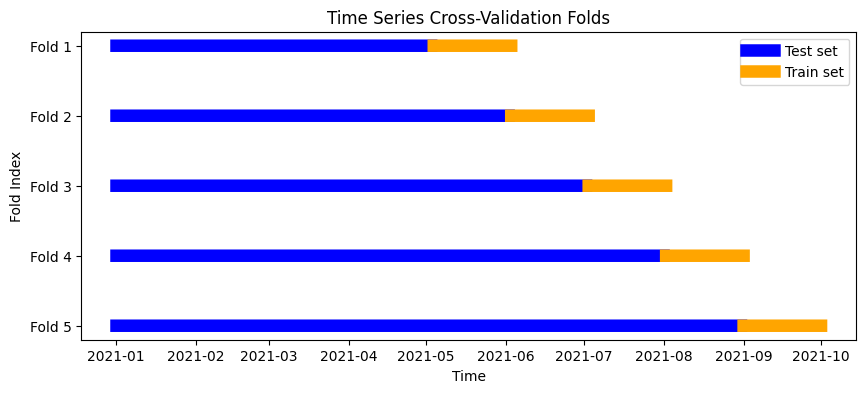

In [224]:
splits = list(tss.split(X_train_data))[::-1]
plt.figure(figsize=(10, 4))

for i, (train_idx, test_idx) in enumerate(splits):
    fold_train = df.iloc[train_idx]
    fold_test = df.iloc[test_idx]
    
    plt.plot(fold_train.index, [i] * len(fold_train), label=f'Train Fold {i}', color='blue', linewidth=9)
    plt.plot(fold_test.index, [i] * len(fold_test), label=f'Test Fold {i}', color='orange', linewidth=9)

plt.title('Time Series Cross-Validation Folds')
plt.xlabel('Time')
plt.ylabel('Fold Index')

plt.legend({'Train set', 'Test set'})

plt.yticks(ticks=range(len(splits)), labels=[f'Fold {len(splits)-i}' for i in range(len(splits))])


Create feature importance graph

In [225]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

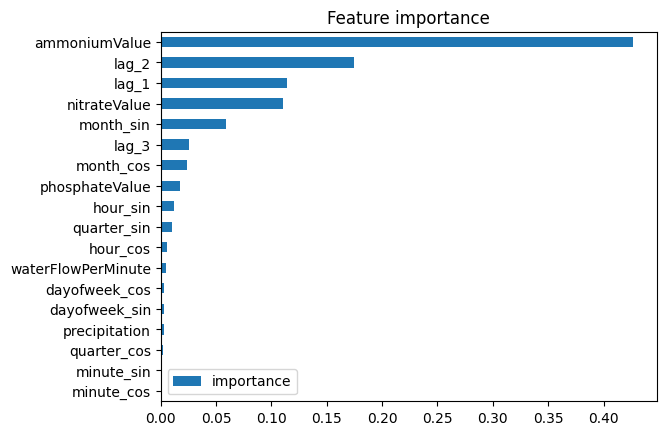

In [226]:
fi.sort_values('importance').plot(kind='barh', title="Feature importance")
plt.show()

In [227]:
print(f'RMSE Score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')
print(f'Mean Absolute Error: {np.mean(mae_scores):0.4f}')
print(f'Mean Absolute Errors per fold: {mae_scores}')

RMSE Score across folds: 0.4706
Fold scores: [0.5080759714802894, 0.6346781606317324, 0.4934640987301108, 0.2346497521018866, 0.48201726212228463]
Mean Absolute Error: 0.3302
Mean Absolute Errors per fold: [0.33318183224988174, 0.4753683481297231, 0.33103324653616667, 0.15507893465375305, 0.3564113146749626]


In [228]:
reg = RandomForestRegressor(**paramsRF)
reg.fit(X_train_data, y_train_data)
pred = pd.DataFrame()
pred['original'] = y_test_data
pred['prediction'] = reg.predict(X_test_data)


In [229]:
rmse = root_mean_squared_error(pred['original'],pred['prediction'])
mae = mean_absolute_error(pred['original'],pred['prediction'])

print(f'RMSE score:{rmse}')
print(f'Mean Absolute Errors: {mae}')

RMSE score:0.4384787806302725
Mean Absolute Errors: 0.2956510905366068


In [230]:
HYPER_PARAMETERS_DF: pd.DataFrame

try:
   HYPER_PARAMETERS_DF =  pd.read_csv('hyperParameters.csv')
except:
    HYPER_PARAMETERS_DF = pd.DataFrame(columns=[
        "bootstrap", "ccp_alpha", "criterion", "max_depth", 
        "max_features", "max_leaf_nodes", "max_samples", 
        "min_impurity_decrease", "min_samples_leaf", "min_samples_split",
        "min_weight_fraction_leaf", "n_estimators", "n_jobs", "oob_score", 
        "random_state", "verbose", "warm_start", "MAE", "RMSE"
    ])

new_row = pd.DataFrame([paramsRF])
new_row['MAE'] = mae
new_row['RMSE'] = rmse
HYPER_PARAMETERS_DF = pd.concat([HYPER_PARAMETERS_DF, new_row], ignore_index=True)

HYPER_PARAMETERS_DF.to_csv('hyperParameters.csv', index=False)

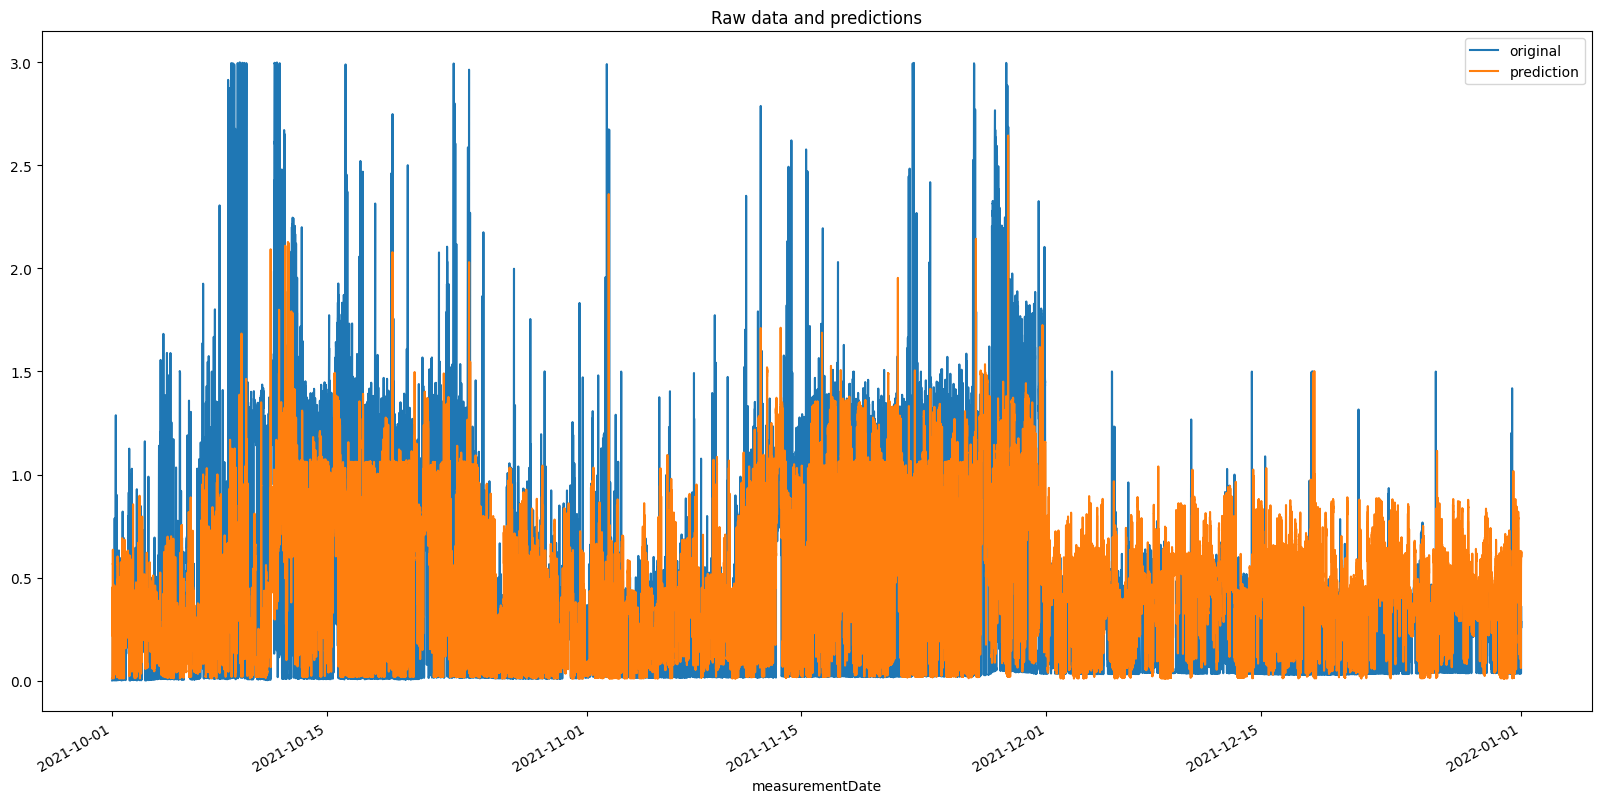

In [231]:
ax = pred[['original']].plot(figsize=(20,10))
pred['prediction'].plot(ax=ax)
plt.legend()
ax.set_title('Raw data and predictions')
plt.show()

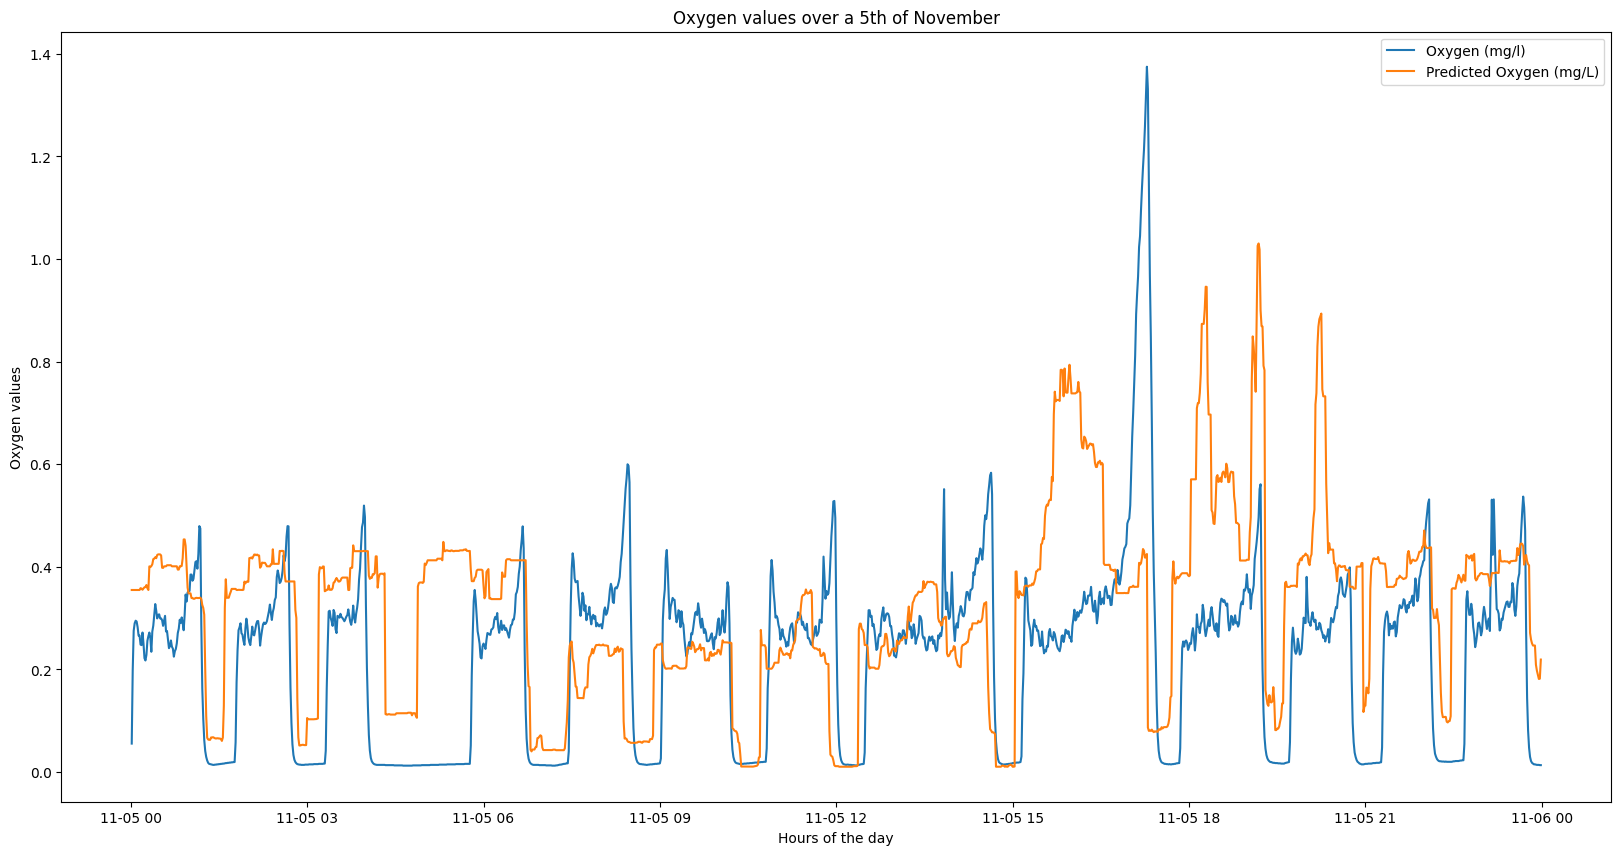

In [232]:
day = pred.loc[(pred.index > '2021-11-05') & (pred.index < '2021-11-06')]

plt.figure(figsize=(20,10))
plt.title("Oxygen values over a 5th of November")
plt.plot(day.index,day['original'])
plt.plot(day.index,day['prediction'])
plt.xlabel('Hours of the day')
plt.ylabel('Oxygen values')
plt.legend(["Oxygen (mg/l)", "Predicted Oxygen (mg/L)"])

In [233]:
#uncoment the following lines if you want to see the decision trees, go grab a coffe/tea, it takes long :)

#plt.figure(figsize=(400,200))
#tree.plot_tree(reg.estimators_[0]),
#plt.savefig('output.png')